In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import math
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

# make the plots pretty 
plt.style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = (12.0, 6.0)

In [2]:
terms = ['brunch', 'breakfast', 'lunch', 'dinner']
columns = ['term', 'time', 'count']
times = np.arange(24)
# times = np.roll(times, -3)
labels = [
  '12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am', '10am', '11am', 
  '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm', '11pm', 
]
labels = np.roll(labels, -3)

labels3 = []
# pretty labels
for l in labels[::3]:
    labels3.append(l)
    labels3.append('')
    labels3.append('')
    
current_palette = sns.color_palette()
colors = {
    'breakfast': current_palette[1],
    'brunch': current_palette[0],
    'lunch': current_palette[2],
    'dinner': current_palette[3],
    'coffee': current_palette[4],
}

x_spline = np.linspace(0, 24, num=1000, endpoint=True)

# convert 4.5 => 4:30am
def htime(hour):
    hour = hour + 3
    ampm = ('am' if (int(hour) < 12) else 'pm')
    h = math.floor(hour) % 12
    if h == 0:
        h = 12
    return "%d:%02d%s" % (h, int(hour % 1 * 60), ampm)

In [3]:
# create the data frame from csv
df = pd.read_csv('tweets_local_hours.csv', header=None, names=columns)
df['gi'] = times[df['time'] - 3]
df = df.sort_values(by=['term', 'gi'])

In [4]:
# create a normalized range for each term
for term in terms:
    tdf = df[df['term'] == term]
    max = tdf['count'].max()
    min = tdf['count'].min()
    
    for index, row in df.iterrows():
        if row['term'] == term:
            df.loc[index, 'normalized'] = ((row['count'] - min) / (max - min) * 100)

In [5]:
# create a pivot table
dfp_time = df.pivot(index='gi', columns='term', values='count')
dfp_norm = df.pivot(index='gi', columns='term', values='normalized')

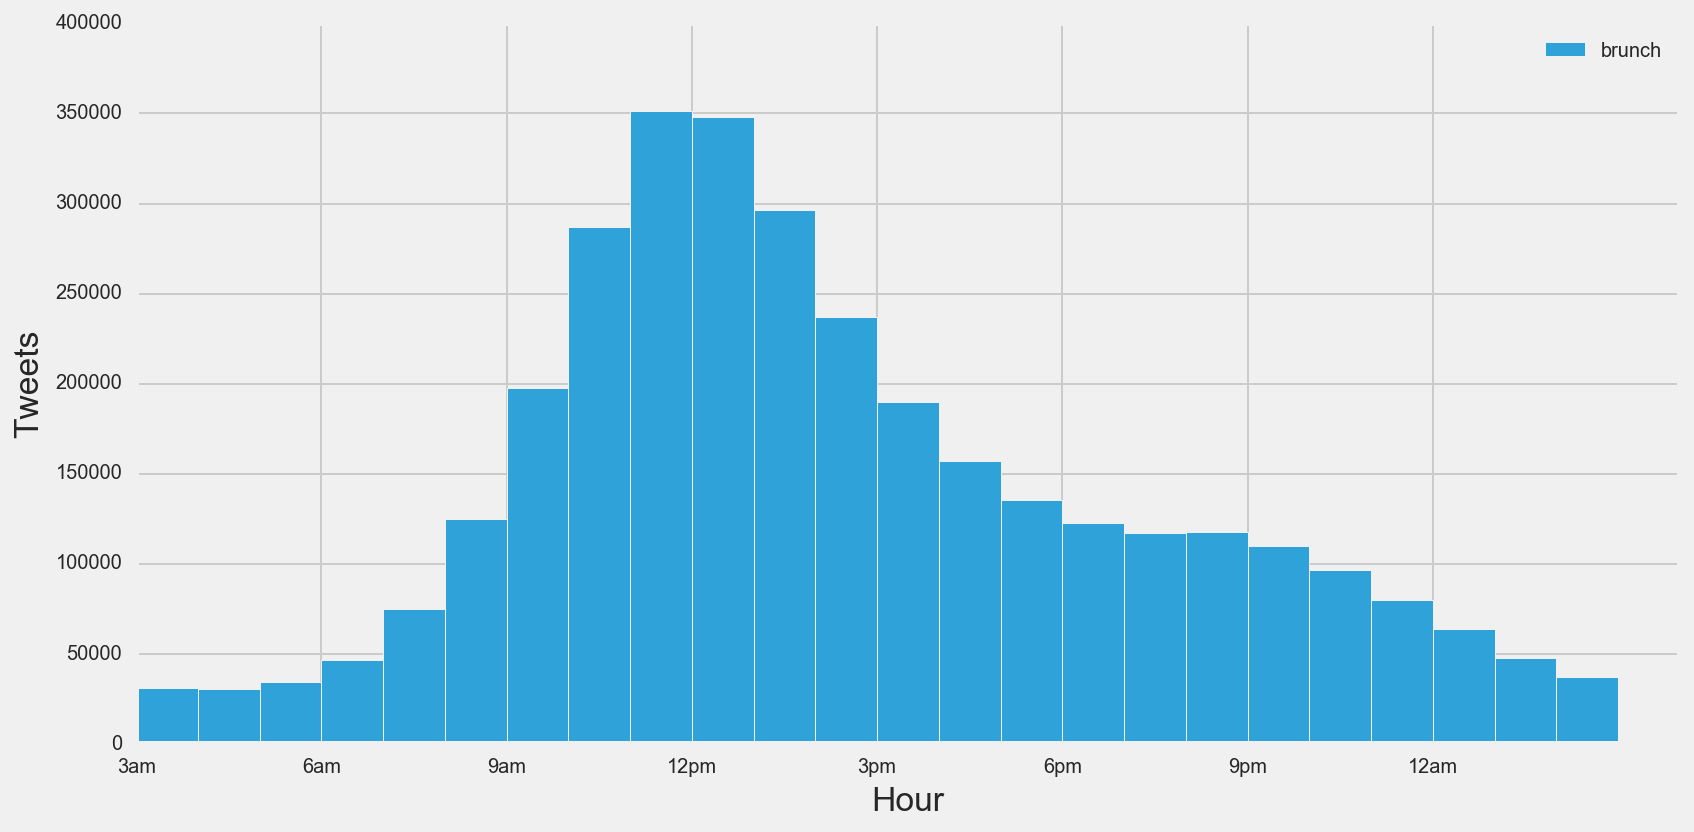

In [6]:
a = plt.bar(times, dfp_time['brunch'], width=1, alpha=1, color=colors['brunch'], label='brunch')
plt.xticks(times[::3], labels[::3], rotation='horizontal')
plt.ylabel('Tweets')
plt.xlabel('Hour')
plt.legend()

plt.tight_layout()
plt.savefig('images/histogram.png', bbox_inches='tight', pad_inches=0.3, dpi=220)
plt.show()

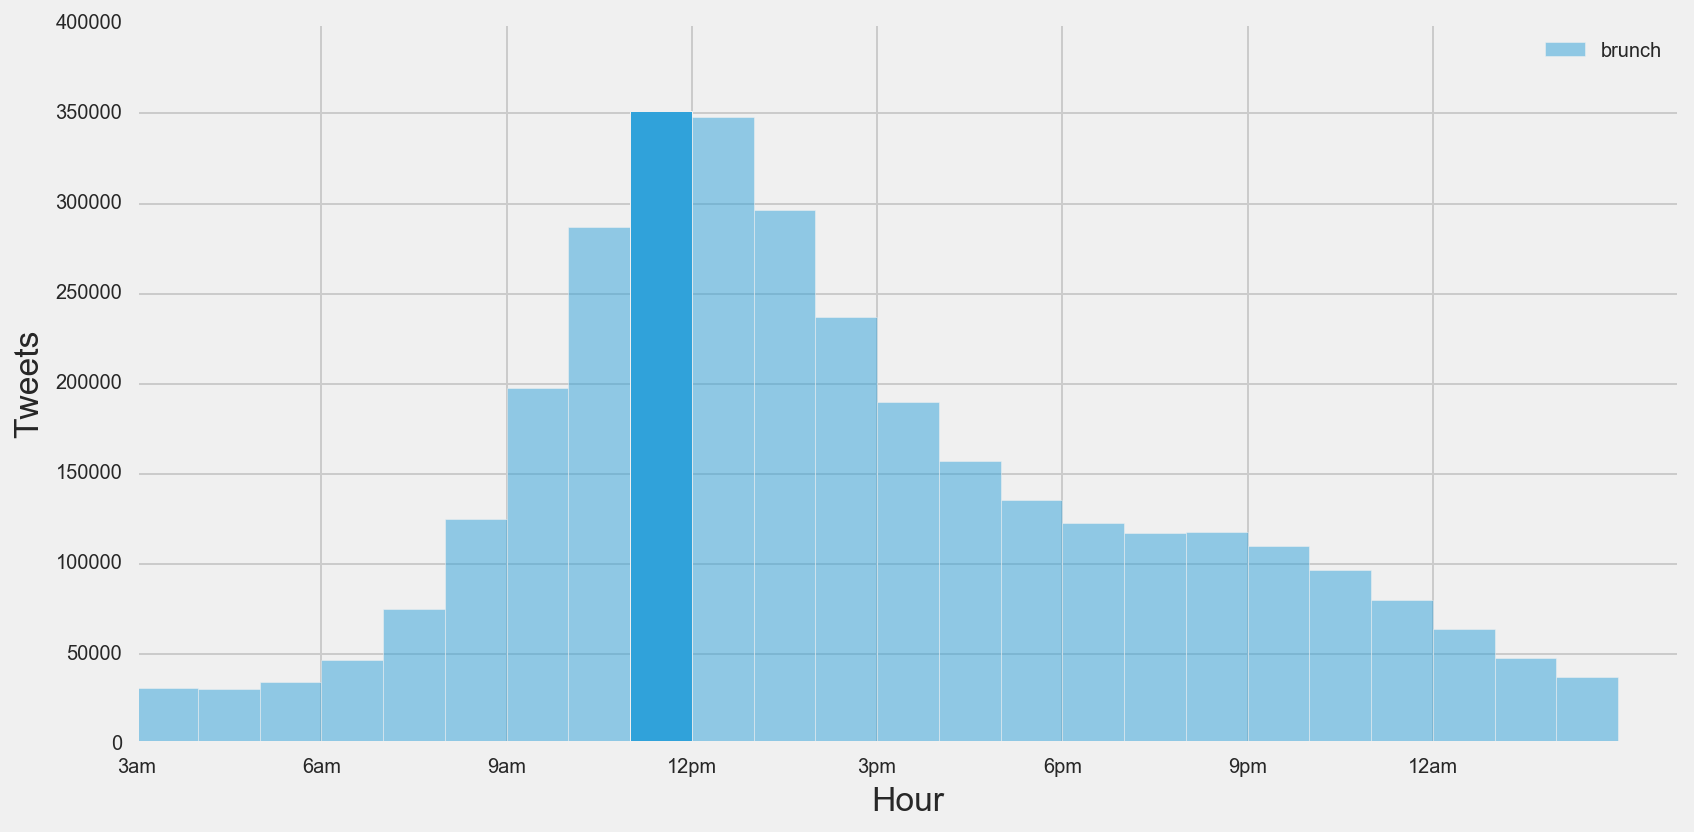

In [7]:
a = plt.bar(times, dfp_time['brunch'], width=1, alpha=0.5, color=colors['brunch'], label='brunch')
maxi = np.argmax(dfp_time['brunch'], axis=0)
a[maxi].set_alpha(1)
plt.xticks(times[::3], labels[::3], rotation='horizontal')
plt.ylabel('Tweets')
plt.xlabel('Hour')
plt.legend()
plt.tight_layout()
plt.savefig('images/histogram_naive.png', bbox_inches='tight', pad_inches=0.3, dpi=220)
plt.show()

std, mean, time(mean) =  4.94036495096 10.9250225836 1:55pm
0.511722962827 0 9.85999292856


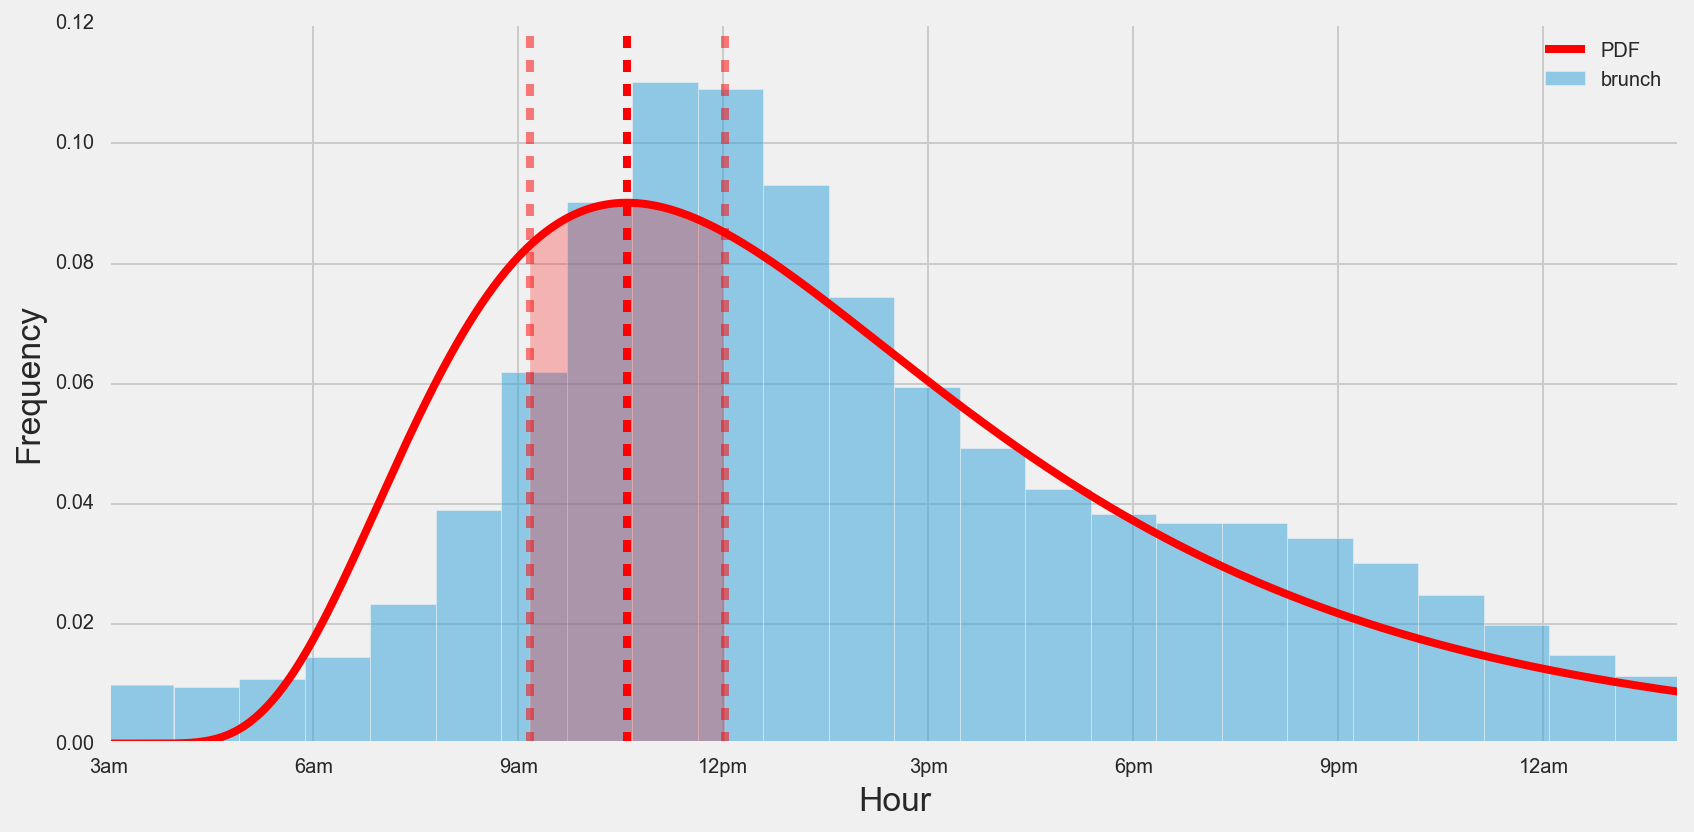

In [8]:
term = 'brunch'

h = []
for i, count in enumerate(dfp_time['brunch']):
    for x in range(int(count / 1000)):
        h.append(i)

h = np.array(h)
h.flatten().flatten()
h = sorted(h)

fit = stats.norm.pdf(h, np.mean(h), np.std(h))

print('std, mean, time(mean) = ', np.std(h), np.mean(h), htime(np.mean(h)))

plt.hist(h, normed=True,bins=24, alpha=0.5, color=colors['brunch'], label=term)
plt.ylabel('Frequency')
plt.xlabel('Hour')
plt.xticks(times[::3], labels[::3], rotation='horizontal')

shape, loc, scale = stats.lognorm.fit(h, floc=0)
print(shape, loc, scale)

shape, loc, scale = stats.lognorm.fit(h, floc=0)
distro = stats.lognorm(shape, loc, scale)
x = np.linspace(0,23,1000)
plt.plot(x, distro.pdf(x), color='r', label="PDF")

# plt.plot(h,fit,'-r')

plt.axvline(x=( (np.argmax(distro.pdf(x)) / 1000) * 23), color='r', ls='--')

max = np.argmax(distro.pdf(x))
x0 = max - 62
x1 = max + 62
plt.axvline(x=x[x0], ls='--', alpha=0.5, color='r')
plt.axvline(x=x[x1], ls='--', alpha=0.5, color='r')

plt.fill(
    [x[x0]] + list(x[x0:x1]) + [x[x1]], [0] + list(distro.pdf(x[x0:x1])) + [0], 
    facecolor='r', alpha=0.25)

plt.legend()
plt.tight_layout()
plt.savefig('images/histogram_pdf.png', bbox_inches='tight', pad_inches=0.3, dpi=220)
plt.show()

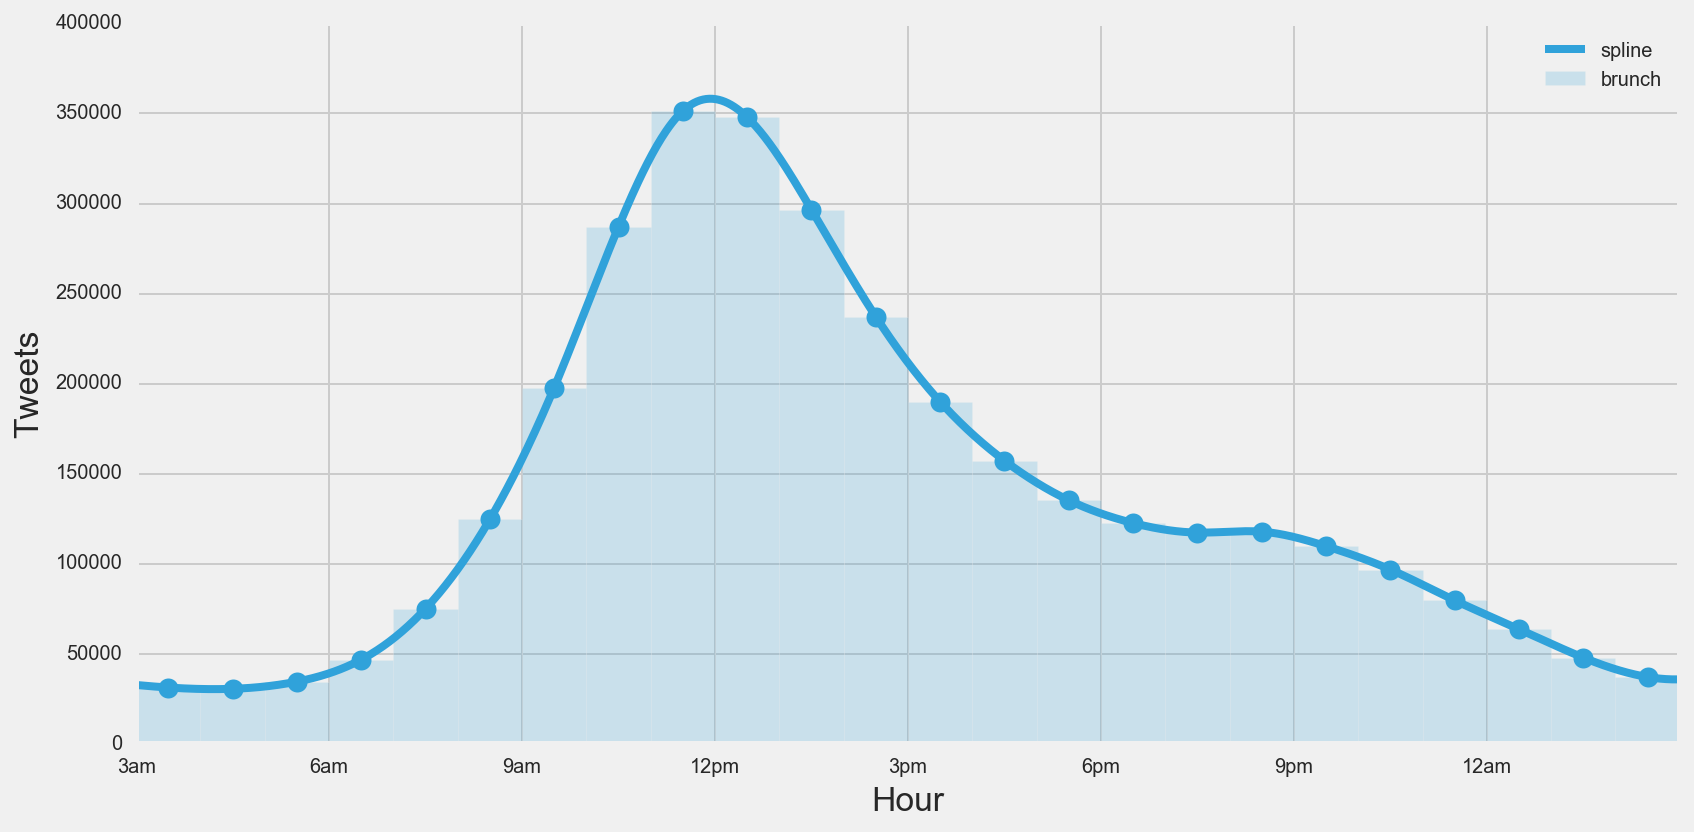

In [9]:
a = plt.bar(times, dfp_time['brunch'], width=1, alpha=0.2, color=colors['brunch'], label='brunch')
plt.xticks(times[::3], labels[::3], rotation='horizontal')
plt.ylabel('Tweets')
plt.xlabel('Hour')

for term in ['brunch']:
    # translate the time by 30 minutes, so the 10-11am bucket has a point at 10:30
    spline = UnivariateSpline(times+0.5, dfp_time[term], s=0)
    plt.plot(times+0.5, dfp_time[term], 'o', alpha=1, color=colors[term], label='_nolegend_', markersize=10)
    plt.plot(x_spline, spline(x_spline), '-', alpha=1, color=colors[term], label='spline')

plt.legend()

plt.tight_layout()
plt.savefig('images/spline.png', bbox_inches='tight', pad_inches=0.3, dpi=220)
plt.show()

372 8.93693693694 358198.041798


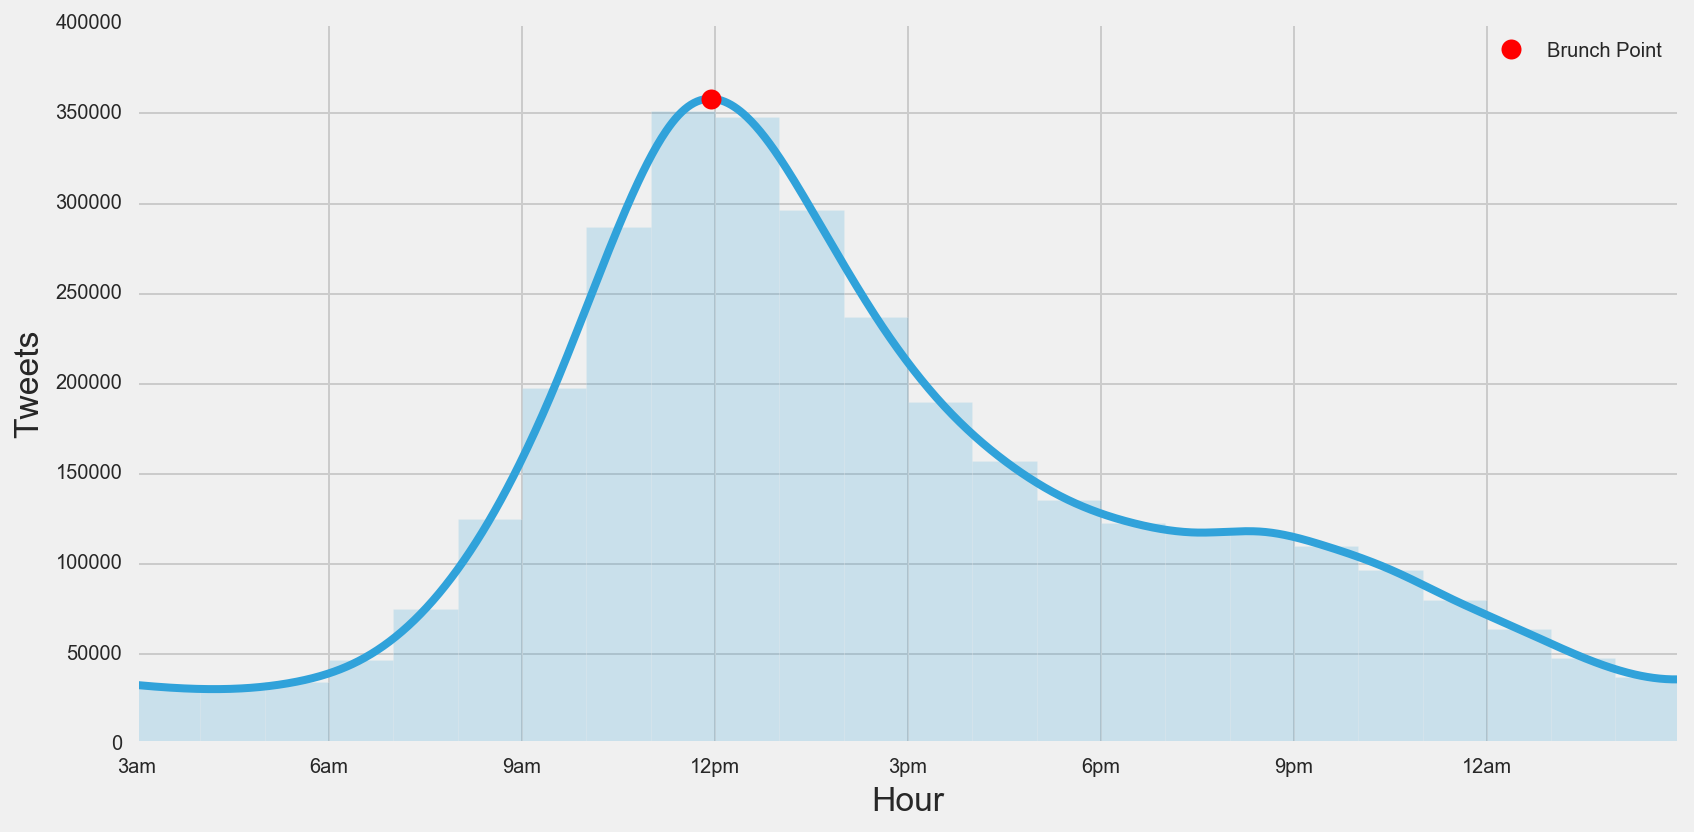

In [10]:
a = plt.bar(times, dfp_time['brunch'], width=1, alpha=0.2, color=colors[term], label='_nolegend_')
plt.xticks(times[::3], labels[::3], rotation='horizontal')
plt.ylabel('Tweets')
plt.xlabel('Hour')

for term in ['brunch']:
    spline = UnivariateSpline(times+0.5, dfp_time[term], s=0)
    maxi = np.argmax(spline(x_spline), axis=0)
    plt.plot(x_spline, spline(x_spline), '-', alpha=1, color=colors[term], label='_nolegend_')
    print(maxi, x_spline[maxi], spline(x_spline)[maxi])
    plt.plot(x_spline[maxi], spline(x_spline)[maxi], 'or', label="Brunch Point", markersize=10)

plt.legend()

plt.tight_layout()
plt.savefig('images/brunchpoint.png', bbox_inches='tight', pad_inches=0.3, dpi=220)
plt.show()

292 10:00am 91286.2749863


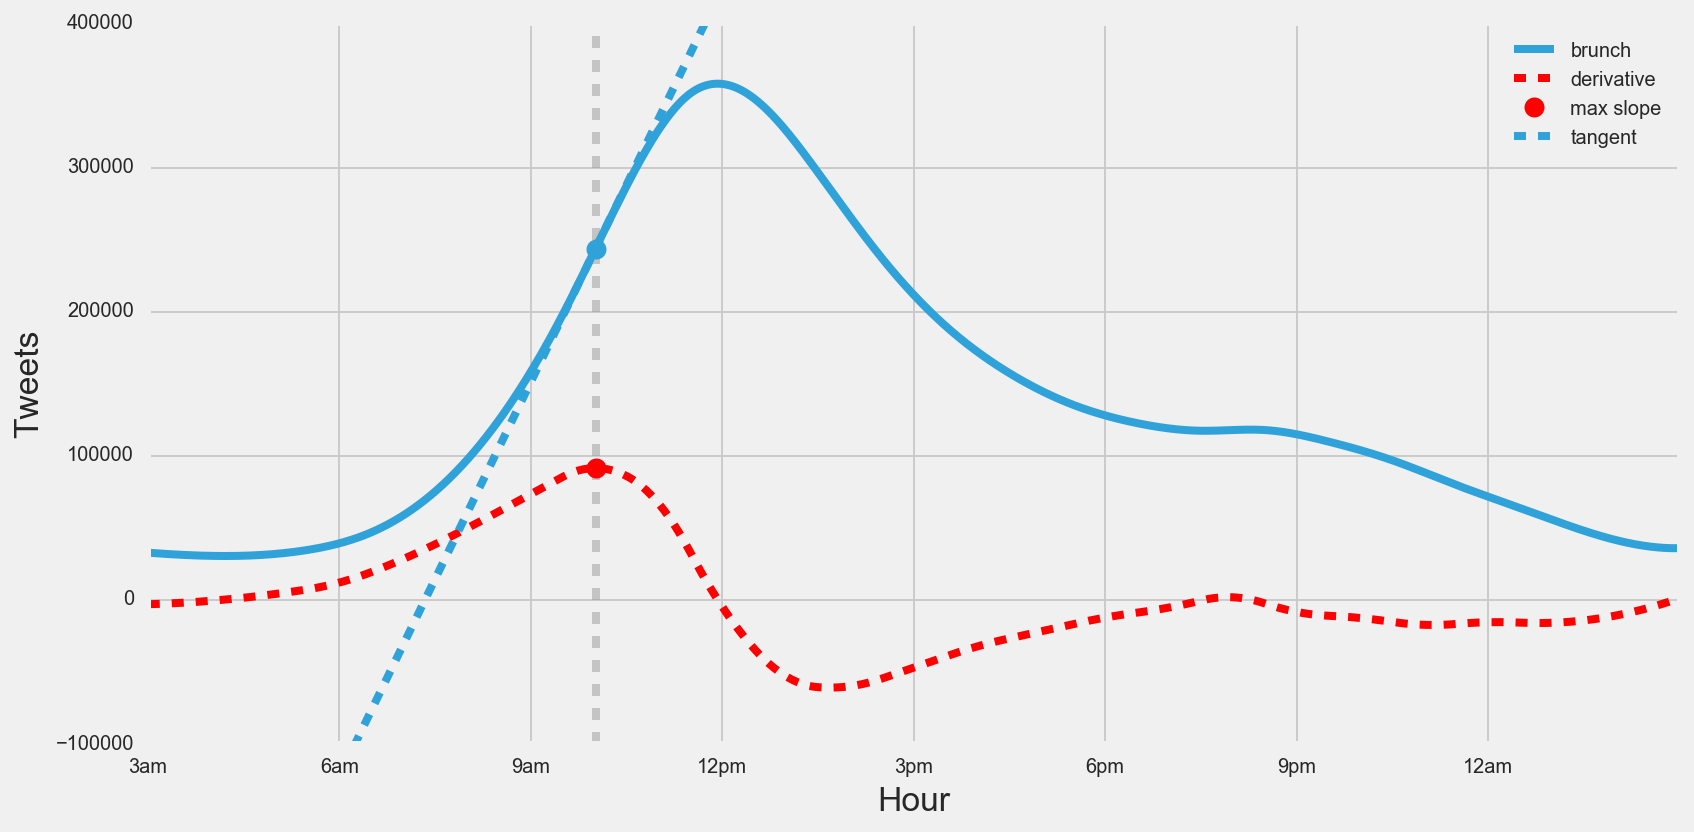

In [11]:
plt.xticks(times[::3], labels[::3], rotation='horizontal')
plt.ylabel('Tweets')
plt.xlabel('Hour')

for term in ['brunch']:
    spline = UnivariateSpline(times+0.5, dfp_time[term], s=0)
    lspline = spline(x_spline)
    d = spline.derivative()(x_spline)
    maxi = np.argmax(d, axis=0)
    print(maxi, htime(x_spline[maxi]), d.max())
    fprime = (lspline[maxi+1] - lspline[maxi]) / (x_spline[maxi+1] - x_spline[maxi])
    # friendlier names:
    m = fprime
    a = maxi
    f = spline
    x = x_spline
    y = lspline
    x1 = x_spline[maxi]
    y1 = lspline[maxi]
    tan = m * (x - x1) + y1
    plt.axvline(x=x1 , ls='dashed', alpha=0.5, color='#999999')
    plt.plot(x_spline, spline(x_spline), '-', alpha=1, color=colors[term], label='brunch')
    plt.plot(x_spline, d, '--r', alpha=1, label='derivative')
    plt.plot(x1, y1,'o', color=colors[term], label="_nolegend_", markersize=10)
    plt.plot(x1, d[a],'or', label="max slope", markersize=10)
    plt.plot(x_spline, tan,'--g', label="tangent", color=colors[term],)
    
plt.legend()
plt.ylim([-100000,400000])
plt.tight_layout()
plt.savefig('images/max_slope.png', bbox_inches='tight', pad_inches=0.3, dpi=220)
plt.show()

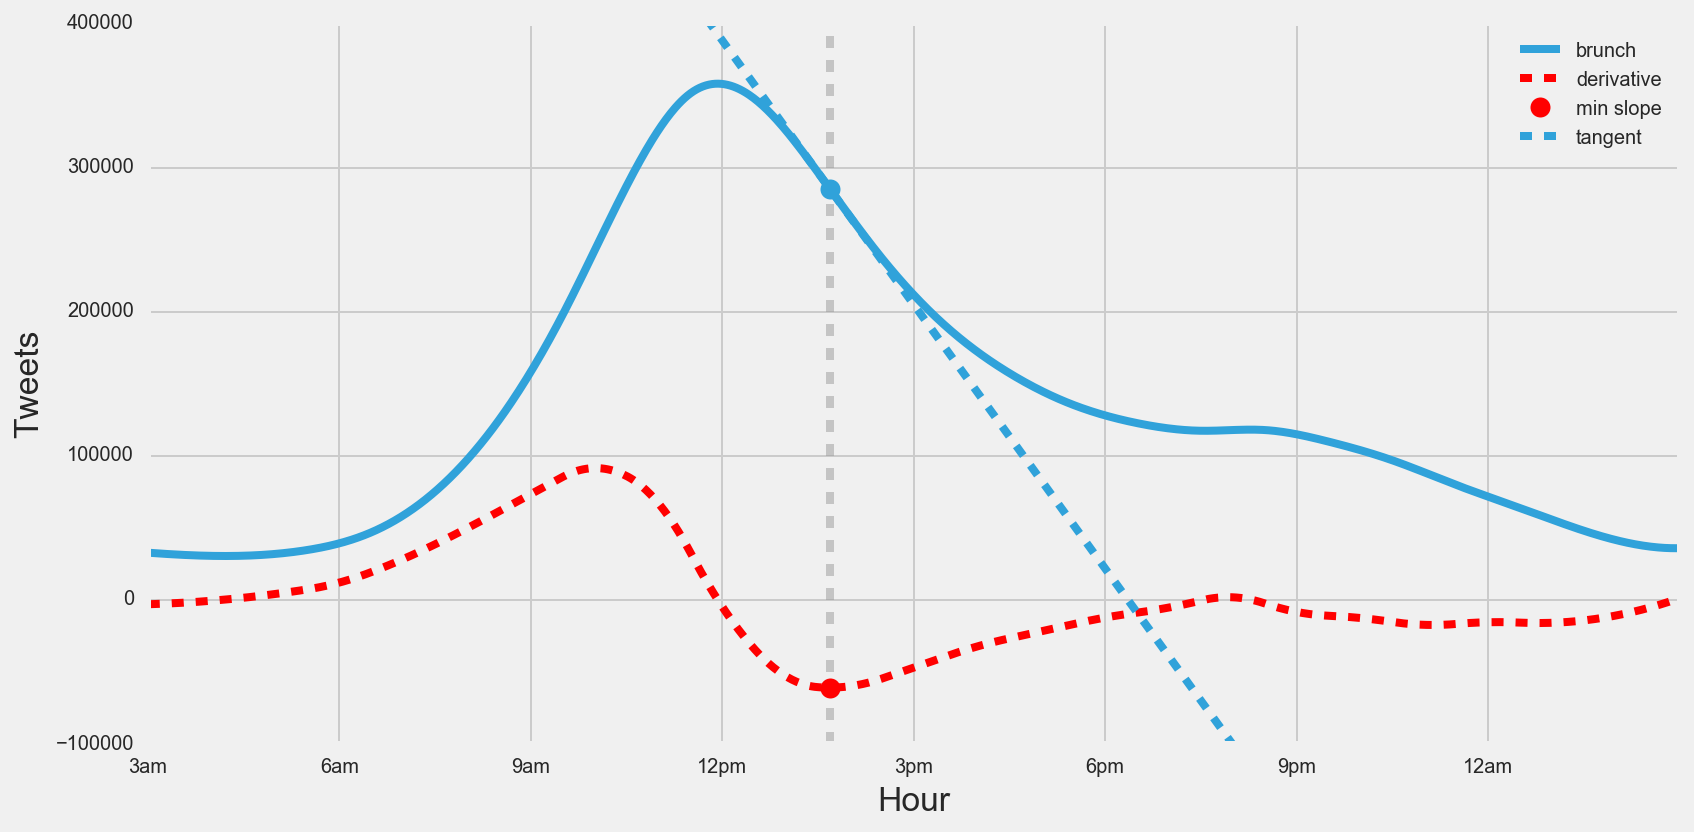

In [12]:
plt.xticks(times[::3], labels[::3], rotation='horizontal')
plt.ylabel('Tweets')
plt.xlabel('Hour')

for term in ['brunch']:
    spline = UnivariateSpline(times+0.5, dfp_time[term], s=0)
    lspline = spline(x_spline)
    d = spline.derivative()(x_spline)
    maxi = np.argmin(d, axis=0)
    fprime = (lspline[maxi+1] - lspline[maxi]) / (x_spline[maxi+1] - x_spline[maxi])
    m = fprime
    a = maxi
    f = spline
    x = x_spline
    y = lspline
    x1 = x_spline[maxi]
    y1 = lspline[maxi]
    tan = m * (x - x1) + y1
    plt.axvline(x=x1 , ls='dashed', alpha=0.5, color='#999999')
    plt.plot(x_spline, spline(x_spline), '-', alpha=1, color=colors[term], label='brunch')
    plt.plot(x_spline, d, '--r', alpha=1, label='derivative')
    plt.plot(x1, y1,'o', color=colors[term], label="_nolegend_", markersize=10)
    plt.plot(x1, d[a],'or', label="min slope", markersize=10)
    plt.plot(x_spline, tan,'--g', label="tangent", color=colors[term])
    
plt.legend()
plt.ylim([-100000,400000])
plt.tight_layout()
plt.savefig('images/min_slope.png', bbox_inches='tight', pad_inches=0.3, dpi=220)
plt.show()

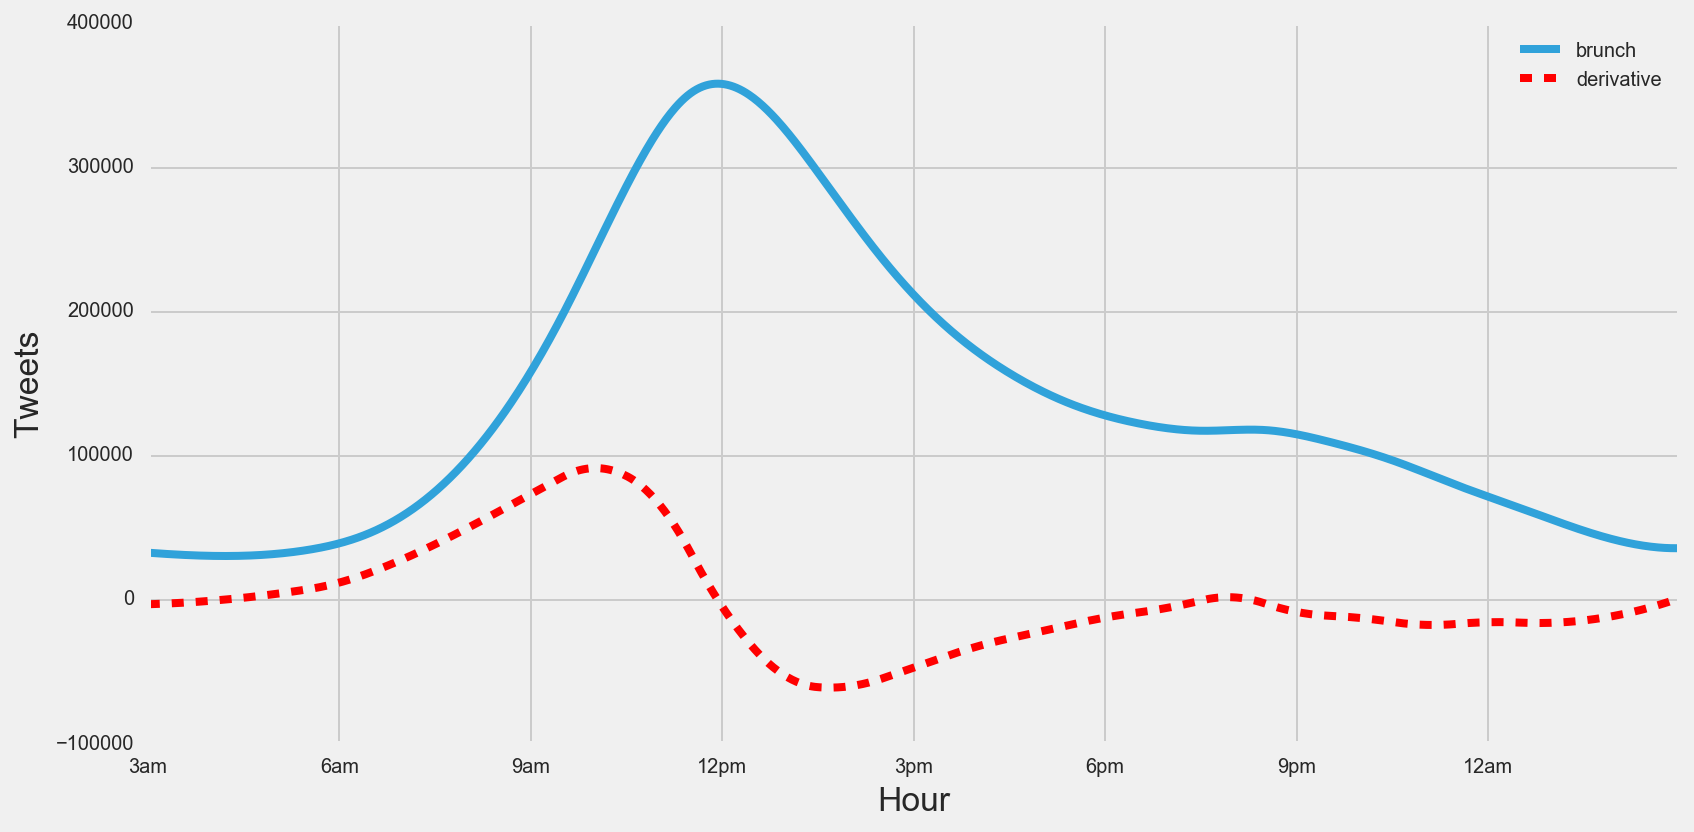

In [13]:
plt.xticks(times[::3], labels[::3], rotation='horizontal')
plt.ylabel('Tweets')
plt.xlabel('Hour')

for term in ['brunch']:
    spline = UnivariateSpline(times+0.5, dfp_time[term], s=0)
    d = spline.derivative()(x_spline)
    plt.plot(x_spline, spline(x_spline), '-', alpha=1, color=colors['brunch'], label='brunch')
    plt.plot(x_spline, d, '--r', alpha=1, label='derivative')

plt.legend()

plt.tight_layout()
plt.savefig('images/derivative.png', bbox_inches='tight', pad_inches=0.3, dpi=220)
plt.show()

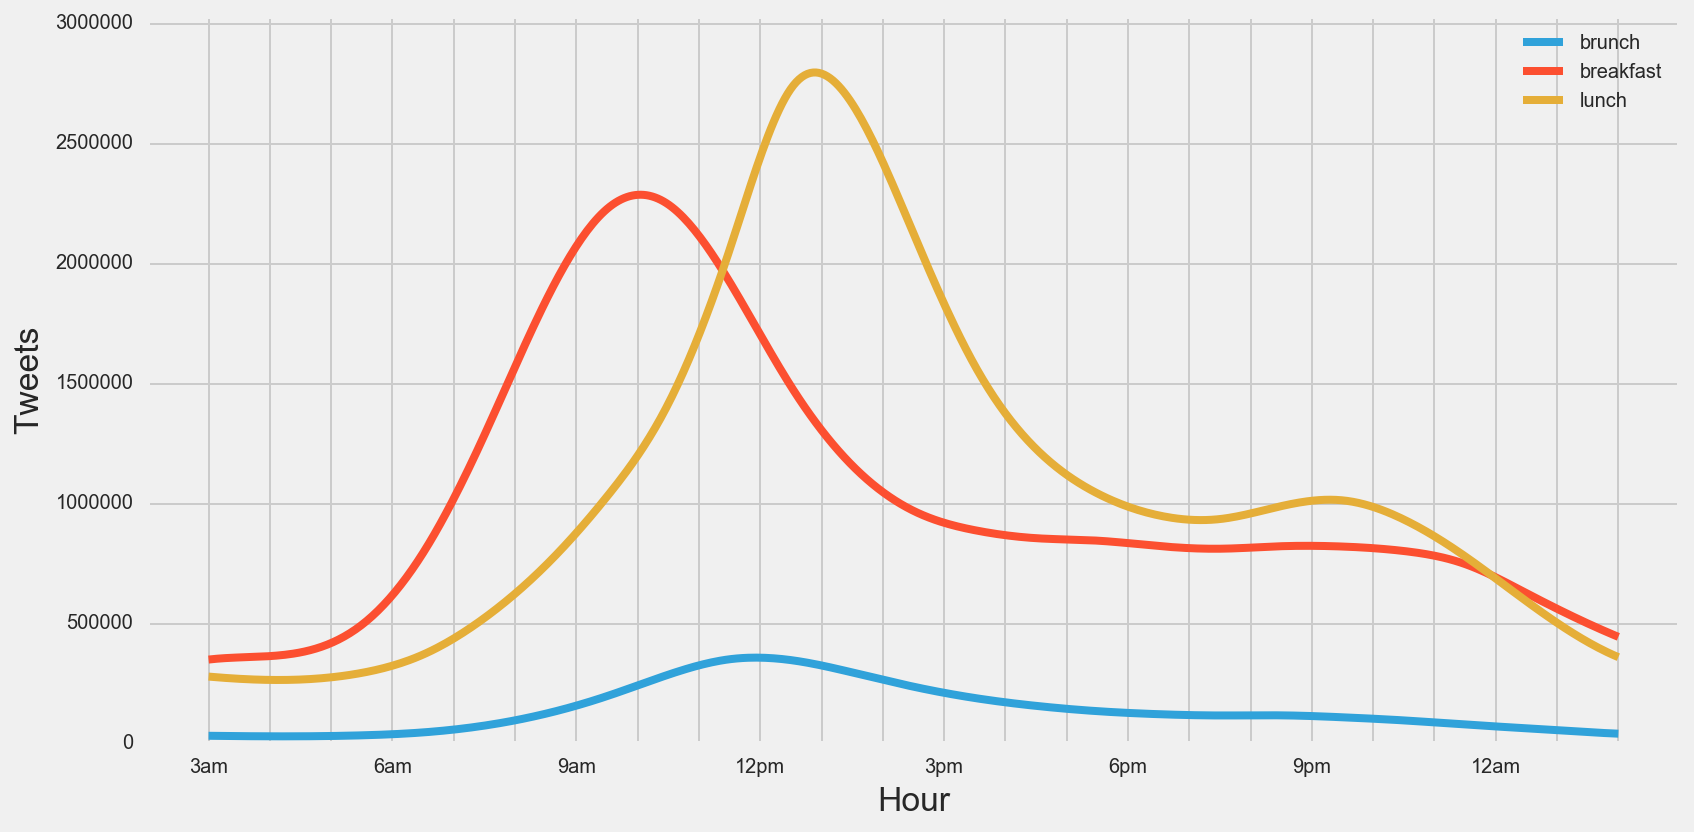

In [14]:
xnew = np.linspace(0, 23, num=500, endpoint=True)

for term in ['brunch', 'breakfast', 'lunch']:
    spline = UnivariateSpline(times + 0.5, dfp_time[term], s=0)
    plt.plot(xnew, spline(xnew), '-', color=colors[term], label=term)
    
plt.ylabel('Tweets')
plt.xlabel('Hour')
plt.xlim([-1,24])
plt.ylim([0,df['count'].max() * 1.1])
plt.xticks(times, labels3, rotation='horizontal')
plt.legend()

plt.tight_layout()
plt.savefig('images/spline_all.png', bbox_inches='tight', pad_inches=0.3, dpi=220)
plt.show()

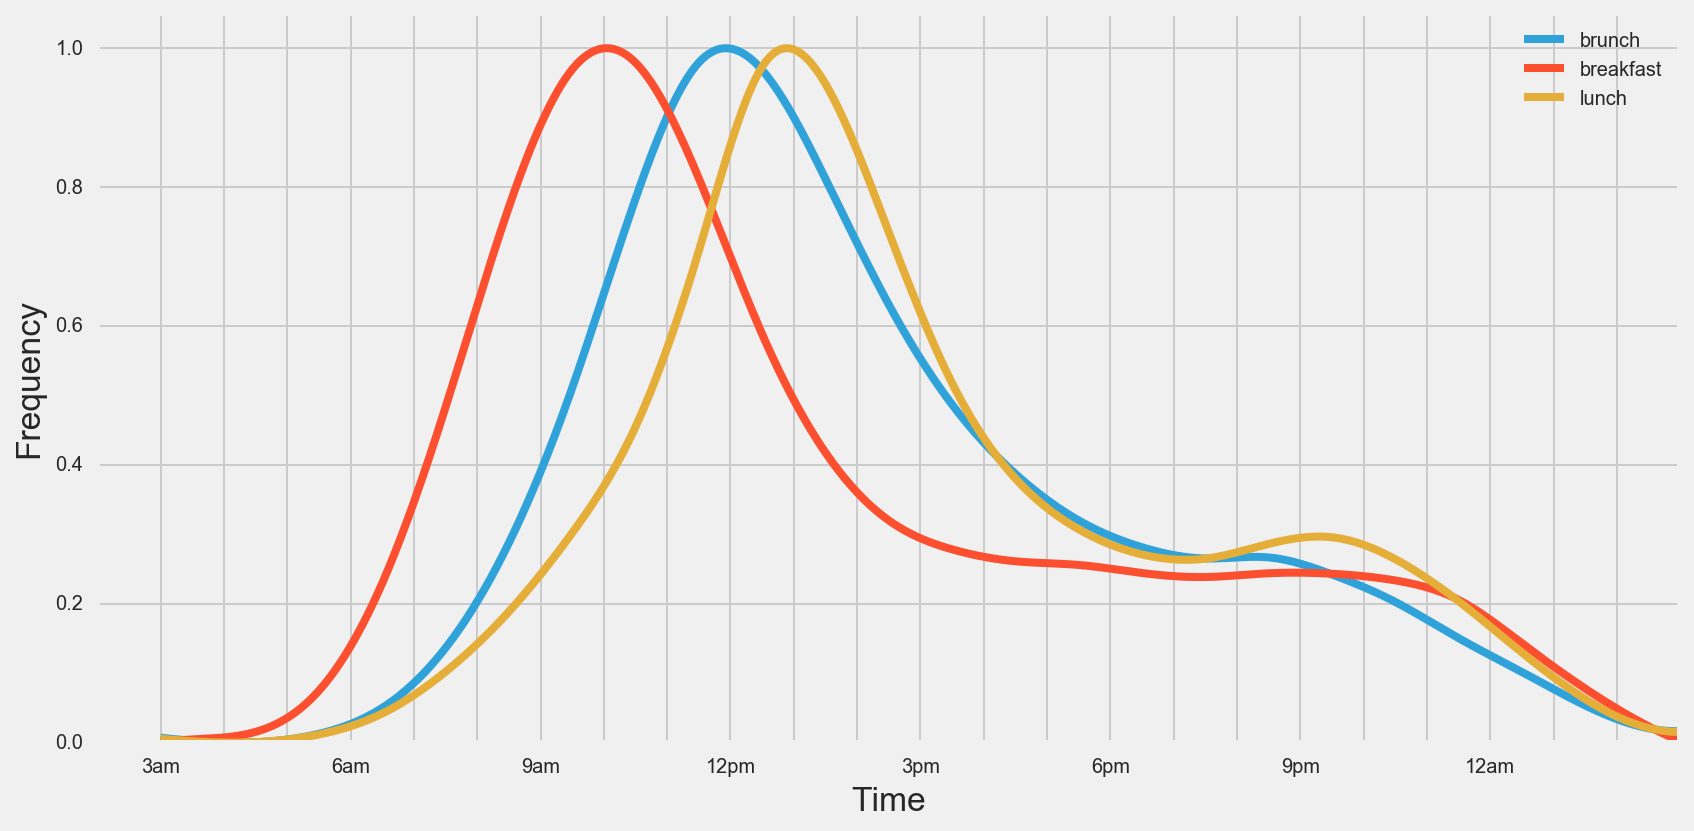

In [15]:
x_norm = np.linspace(0, 23, num=1000, endpoint=True)

splines = {}
for term in ['brunch', 'breakfast', 'lunch']:
    spline = UnivariateSpline(times + 0.5, dfp_time[term], s=0)
    smax = spline(x_norm).max()
    smin = spline(x_norm).min()
    splines[term] = ((spline(x_spline) - smin) / (smax - smin))
    plt.plot(x_spline, splines[term], '-', color=colors[term], label=term)
    
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.xlim([-1,24])
plt.ylim([0,1.05])
plt.xticks(times, labels3, rotation='horizontal')
plt.legend()

plt.tight_layout()
plt.savefig('images/spline_all_freq.png', bbox_inches='tight', pad_inches=0.3, dpi=220)
plt.show()

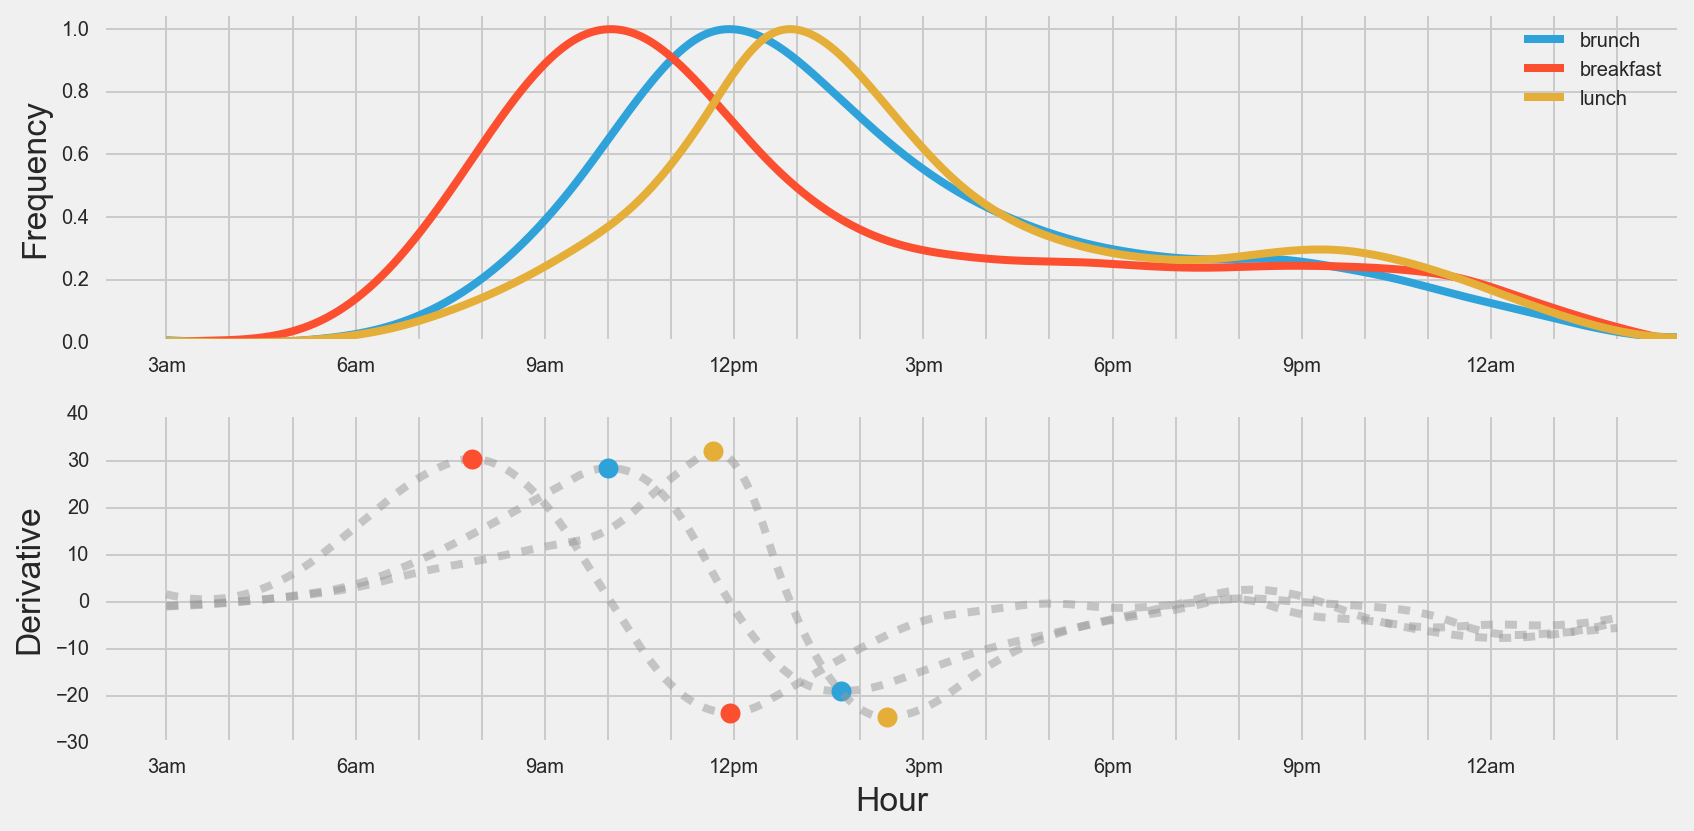

In [16]:
from matplotlib import gridspec

xnew = np.linspace(0, 23, num=500, endpoint=True)
fig = plt.figure()

plot_terms = ['brunch', 'breakfast', 'lunch']

gs = gridspec.GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,:])

plt.sca(ax1)

plt.xlim([-1,24])
plt.ylim([0,1.05])

plt.xticks(times, labels3, rotation='horizontal')
plt.ylabel('Frequency')
for term in plot_terms:
    spline = UnivariateSpline(times + 0.5, dfp_time[term], s=0)
    smax = spline(x_norm).max()
    smin = spline(x_norm).min()
    fspline = ((spline(x_spline) - smin) / (smax - smin))
    plt.plot(x_spline, fspline, '-', color=colors[term], label=term)

plt.legend()

plt.sca(ax2)
plt.xlim([-1,24])
plt.xticks(times, labels3, rotation='horizontal')
plt.ylabel('Derivative')

for term in plot_terms:
    spline = UnivariateSpline(times + 0.5, dfp_norm[term], s=0)
    d = spline.derivative()(xnew)
    plt.plot(xnew, d, '--', alpha=0.5, color='#999999')
    # plot black bars
    plt.plot(xnew[np.argmax(d, axis=0)], d[np.argmax(d, axis=0)], 'o', color=colors[term], markersize=10)
    plt.plot(xnew[np.argmin(d, axis=0)], d[np.argmin(d, axis=0)], 'o', color=colors[term], markersize=10)
              
        
plt.xlabel('Hour')

plt.tight_layout()
plt.savefig('images/spline_all_deriv.png', bbox_inches='tight', pad_inches=0.3, dpi=220)
plt.show()

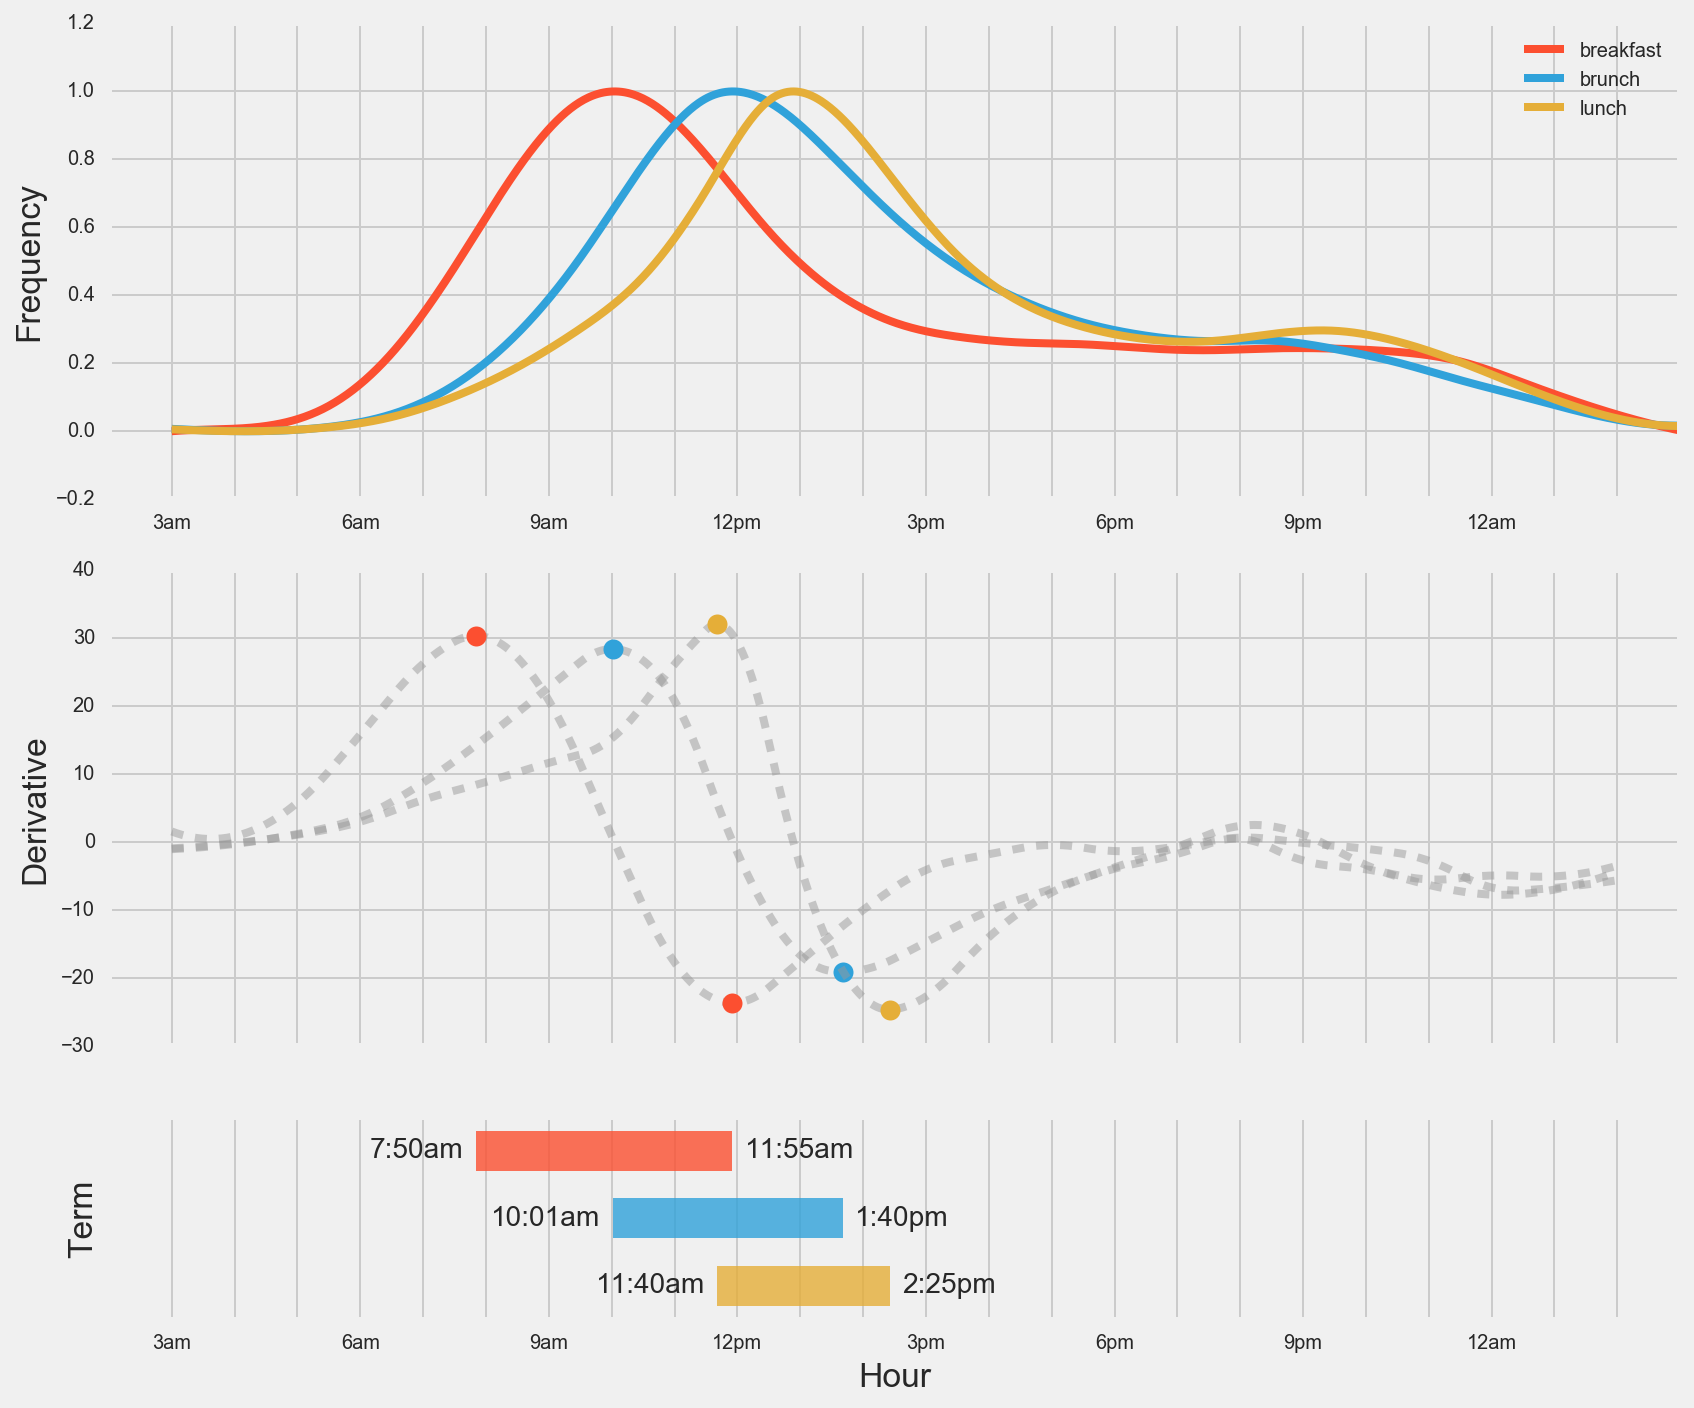

In [17]:
from matplotlib import gridspec

xnew = np.linspace(0, 23, num=24 * 60, endpoint=True)
fig = plt.figure()
fig.set_size_inches(12.0, 10.0)


#plot_terms = ['breakfast', 'brunch', 'lunch', 'dinner', 'coffee'] # terms
plot_terms = ['breakfast', 'brunch', 'lunch'] # terms

gs = gridspec.GridSpec(5, 2)
ax1 = fig.add_subplot(gs[0:2,:])
ax2 = fig.add_subplot(gs[2:4,:])
ax3 = fig.add_subplot(gs[4,:])
plt.sca(ax1)

plt.xlim([-1,24])
plt.xticks(times, labels3, rotation='horizontal')

plt.ylabel('Frequency')
for term in plot_terms:
    spline = UnivariateSpline(times + 0.5, dfp_time[term], s=0)
    smax = spline(x_norm).max()
    smin = spline(x_norm).min()
    fspline = ((spline(x_spline) - smin) / (smax - smin))
    plt.plot(x_spline, fspline, '-', color=colors[term], label=term)


plt.legend()

plt.sca(ax2)
plt.xlim([-1,24])

plt.xticks(times, [''] * 10, rotation='horizontal')

plt.ylabel('Derivative')

for term in plot_terms:
    spline = UnivariateSpline(times + 0.5, dfp_norm[term], s=0)
    d = spline.derivative()(xnew)
    plt.plot(xnew, d, '--', alpha=0.5, color='#999999')
    plt.plot(xnew[np.argmax(d, axis=0)], d[np.argmax(d, axis=0)], 'o', color=colors[term], markersize=10)
    plt.plot(xnew[np.argmin(d, axis=0)], d[np.argmin(d, axis=0)], 'o', color=colors[term], markersize=10)
    
plt.sca(ax3)
plt.xlim([-1,24])
plt.xticks(times, labels3, rotation='horizontal')
plt.yticks([])
plt.ylim([-0.5,len(plot_terms)-0.5])
plt.ylabel('Term')
for i, term in enumerate(reversed(plot_terms)):
    spline = UnivariateSpline(times + 0.5, dfp_norm[term], s=0)
    d = spline.derivative()(xnew)
    plt.hlines(i, xnew[np.argmax(d, axis=0)], xnew[np.argmin(d, axis=0)], 
               linewidth=20, color=colors[term], label=term, alpha=0.8)
    start = htime(xnew[np.argmax(d, axis=0)])
    xy = (xnew[np.argmax(d, axis=0)] - 0.2, i-0.1)
    ax3.annotate(start, xy=xy, xytext=xy, horizontalalignment='right')
    finish = htime(xnew[np.argmin(d, axis=0)])
    xy = (xnew[np.argmin(d, axis=0)] + 0.2, i-0.1)
    ax3.annotate(finish, xy=xy, xytext=xy, horizontalalignment='left')
    
plt.xlabel('Hour')

plt.tight_layout()
plt.savefig('images/spline_all_deriv2.png', bbox_inches='tight', pad_inches=0.3, dpi=220)
plt.show()